In [19]:

!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [20]:

!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [21]:
#
from transformers import pipeline
sentiment_pipeline=pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [22]:
data=['i love you','i hate you']

In [23]:
sentiment_pipeline(data)

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [24]:
#Data Loading and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import csv

# Initialize an empty list to hold the rows
data = []

# Open the CSV file and read line by line
with open("/content/IMDB Dataset.csv", newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        data.append(row)

# Convert the list of rows into a DataFrame
df = pd.DataFrame(data[1:], columns=data[0])

print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [31]:
df.shape

(3181, 2)

In [32]:
df.shape
df.isnull().sum()

review       0
sentiment    1
dtype: int64

In [34]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords corpus if you haven't already
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
# Word count function
def get_wordcounts(text):
    return len(text.split())

# Character count function
def get_charcounts(text):
    return len(text)

# Average word length function
def get_avg_wordlength(text):
    words = text.split()
    if len(words) == 0:
        return 0
    total_length = sum(len(word) for word in words)
    return total_length / len(words)

# Count stopwords function
def get_stopwords_counts(text):
    stopwords_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopwords_list)
    return stopwords_count

# Apply preprocessing functions to the DataFrame
df['word_counts'] = df['review'].apply(get_wordcounts)
df['char_counts'] = df['review'].apply(get_charcounts)
df['avg_wordlength'] = df['review'].apply(get_avg_wordlength)
df['stopwords_counts'] = df['review'].apply(get_stopwords_counts)

# Display the DataFrame with the new features
print(df.head())


                                              review sentiment  word_counts  \
0  One of the other reviewers has mentioned that ...  positive          307   
1  A wonderful little production. <br /><br />The...  positive          162   
2  I thought this was a wonderful way to spend ti...  positive          166   
3  Basically there's a family where a little boy ...  negative          138   
4  Petter Mattei's "Love in the Time of Money" is...  positive          230   

   char_counts  avg_wordlength  stopwords_counts  
0         1761        4.739414               133  
1          998        5.166667                66  
2          926        4.584337                76  
3          748        4.427536                62  
4         1317        4.730435                96  


In [36]:

# Function to remove HTML tags
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Convert 'review' column to lowercase
df['review'] = df['review'].str.lower()

# Remove HTML tags from 'review' column
df['review'] = df['review'].apply(remove_html_tags)

# Display the DataFrame head
print(df.head())

                                              review sentiment  word_counts  \
0  one of the other reviewers has mentioned that ...  positive          307   
1  a wonderful little production. the filming tec...  positive          162   
2  i thought this was a wonderful way to spend ti...  positive          166   
3  basically there's a family where a little boy ...  negative          138   
4  petter mattei's "love in the time of money" is...  positive          230   

   char_counts  avg_wordlength  stopwords_counts  
0         1761        4.739414               133  
1          998        5.166667                66  
2          926        4.584337                76  
3          748        4.427536                62  
4         1317        4.730435                96  


<Axes: >

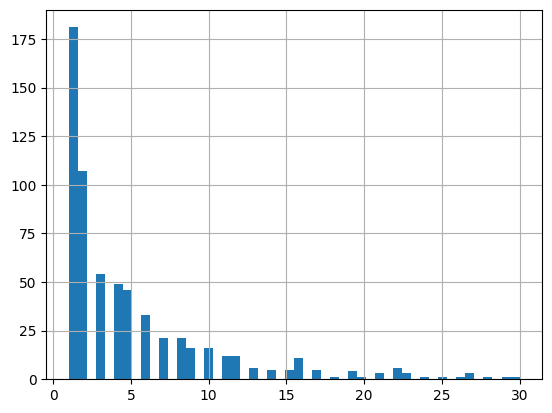

In [37]:

df['word_counts'].value_counts().hist(bins=50)

In [38]:
# custom dataset -> evaluation/compute metrics -> training arguments -> trainer -> training -> testing

In [39]:

import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [63]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels  # Labels should be one-hot encoded
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # Assuming labels are already one-hot encoded

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len)

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': label
        }



In [64]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
X = df['review'].tolist()

label2id = {'positive': 1, 'negative': 0}
id2label = {1: 'positive', 0: 'negative'}

y = df['sentiment'].map(label2id).tolist()

dataset = CustomDataset(X, y, tokenizer)

In [66]:
dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [67]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [68]:

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(example):
  labels = example.label_ids
  preds = example.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {'accuracy': acc, "f1": f1}

In [69]:
from transformers.trainer import TrainingArguments

batch_size = 16
model_name = "distilbert_finetuned_sentiment"

args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=1,
    evaluation_strategy='epoch'
)

In [70]:
from transformers import Trainer, TrainingArguments
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics=compute_metrics,
                  tokenizer = tokenizer)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()



In [ ]:
trainer.save_model(model_name)

In [ ]:
# Model Testing

text = "i love this product"
pipe = pipeline('text-classification', model_name)
pipe(text)


In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)
mod = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def get_prediction(text):
  input_ids = tok.encode(text, return_tensors='pt')
  output = mod(input_ids)

  preds = torch.nn.functional.softmax(output.logits, dim=-1)

  prob = torch.max(preds).item()

  idx = torch.argmax(preds).item()
  sentiment = id2label[idx]

  return {'sentiment':sentiment, 'prob':prob}

In [ ]:
text = "i love this product"
get_prediction(text)


In [ ]:
text = "i hate this product"
get_prediction(text)

In [ ]:
import nltk
from nltk.corpus import stopwords

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


-rw-r--r-- 1 root root 66212309 Mar 29 08:12 '/content/IMDB Dataset.csv'
text/csv; charset=utf-8
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              review sentiment  word_counts  \
0  One of the other reviewers has mentioned that ...  positive          307   
1  A wonderful little production. <br /><br />The...  positive          162   
2  I thought this was a wonderful way to spend ti...  positive          166   
3  Basically there's a family where a little boy ...  negative          138   
4  Petter Mattei's "Love in the Time of Money" is...  positive          230   

   char_counts  avg_wordlength  stopwords_counts  
0         1761        4.739414               133  
1          998        5.166667                66  
2          926        4.584337                76  
3          748        4.427536                62  
4         1317        4.730435                96  
                                              review sentiment  word_counts  \
0  one of the other reviewers has mentioned that ...  positive          307   
1  a wonderful little production. the filming tec...  positiv

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.199400,0.187315,0.930500,0.930483


{'sentiment': 'negative', 'prob': 0.9727030992507935}

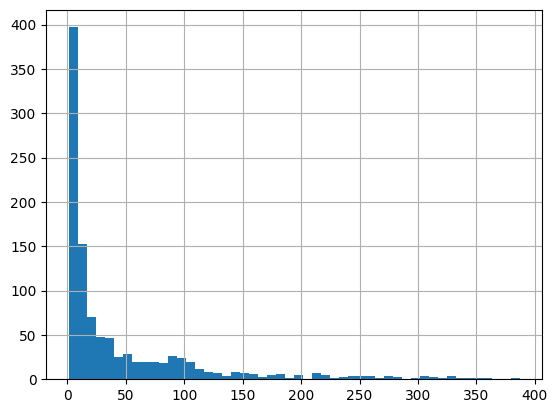

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
sentiment_pipeline=pipeline("sentiment-analysis")

data=['i love you','i hate you']

sentiment_pipeline(data)

#Data Loading and Preprocessing


# Initialize an empty list to hold the rows
data = []

# Open the CSV file and read line by line
with open("/content/IMDB Dataset.csv", newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        data.append(row)

# Convert the list of rows into a DataFrame
df = pd.DataFrame(data[1:], columns=data[0])




# Download the stopwords corpus if you haven't already
nltk.download('stopwords')

# Word count function
def get_wordcounts(text):
    return len(text.split())

# Character count function
def get_charcounts(text):
    return len(text)

# Average word length function
def get_avg_wordlength(text):
    words = text.split()
    if len(words) == 0:
        return 0
    total_length = sum(len(word) for word in words)
    return total_length / len(words)

# Count stopwords function
def get_stopwords_counts(text):
    stopwords_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopwords_list)
    return stopwords_count

# Apply preprocessing functions to the DataFrame
df['word_counts'] = df['review'].apply(get_wordcounts)
df['char_counts'] = df['review'].apply(get_charcounts)
df['avg_wordlength'] = df['review'].apply(get_avg_wordlength)
df['stopwords_counts'] = df['review'].apply(get_stopwords_counts)

# Display the DataFrame with the new features
# print(df.head())

# Function to remove HTML tags
def remove_html_tags(text):
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Convert 'review' column to lowercase
df['review'] = df['review'].str.lower()

# Remove HTML tags from 'review' column
df['review'] = df['review'].apply(remove_html_tags)

# Display the DataFrame head
print(df.head())

df['word_counts'].value_counts().hist(bins=50)

# custom dataset -> evaluation/compute metrics -> training arguments -> trainer -> training -> testing



class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels  # Labels should be one-hot encoded
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # Assuming labels are already one-hot encoded

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len)

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': label
        }



checkpoint = 'distilbert-base-uncased'
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

X = df['review'].tolist()

label2id = {'positive': 1, 'negative': 0}
id2label = {1: 'positive', 0: 'negative'}

y = df['sentiment'].map(label2id).tolist()

dataset = CustomDataset(X, y, tokenizer)

dataset[0].keys()

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, "f1": f1}



batch_size = 16
model_name = "distilbert_finetuned_sentiment"

args = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=1,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

trainer.save_model(model_name)

# Model Testing

text = "i love this product"
pipe = pipeline('text-classification', model_name)
pipe(text)

tok = AutoTokenizer.from_pretrained(model_name)
mod = AutoModelForSequenceClassification.from_pretrained(model_name)

def get_prediction(text):
  input_ids = tok.encode(text, return_tensors='pt')
  output = mod(input_ids)

  preds = torch.nn.functional.softmax(output.logits, dim=-1)

  prob = torch.max(preds).item()

  idx = torch.argmax(preds).item()
  sentiment = id2label[idx]

  return {'sentiment':sentiment, 'prob':prob}

text = "i love this product"
get_prediction(text)

text = "i hate this product"
get_prediction(text)

In [75]:
!ls output/checkpoint-2500/

config.json	   rng_state.pth	    tokenizer_config.json  training_args.bin
model.safetensors  scheduler.pt		    tokenizer.json	   vocab.txt
optimizer.pt	   special_tokens_map.json  trainer_state.json


In [76]:
from transformers import AutoModelForSequenceClassification

# Specify the directory where your model is saved
model_directory = "output/checkpoint-2500/"

# Load the model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_directory)


In [77]:
# Example of using the loaded model to make predictions
text = "I am feeling happy"
input_ids = tokenizer.encode(text, return_tensors='pt')
output = loaded_model(input_ids)
predicted_class = output.logits.argmax().item()

# Map the predicted class to the sentiment label
predicted_sentiment = id2label[predicted_class]

print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: positive


In [79]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.4/312.4 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.1 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl s

In [89]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import gradio as gr

# Load model and tokenizer
model_name = "output/checkpoint-2500/"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define prediction function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)
    sentiment = "Positive" if probabilities[0][1] > 0.5 else "Negative"
    return sentiment

# Create Gradio interface
text_input = gr.Textbox(lines=7, label="Input Text", placeholder="Enter your text here...")
output_text = gr.Textbox(label="Predicted Sentiment")

# Author information
author = "Ajeetkumar Ukande"

# Create Gradio interface
interface = gr.Interface(predict_sentiment, text_input, output_text,
             title="<div style='color: #336699; font-size: 24px; font-weight: bold; border: 2px solid #336699; padding: 10px; border-radius: 10px;'>Sentiment Analysis</div>",
             description=f"""<div style='color: #666666; font-family: Arial, sans-serif;'>
                             <p style='margin-top: 10px;'>This model predicts the sentiment of text.</p>
                             <p>It uses a fine-tuned DistilBERT model trained on IMDb movie reviews dataset.</p>
                             <p>The sentiment is classified as Positive if the probability of positive sentiment is greater than 0.5, otherwise it's classified as Negative.</p>
                             <p>Developed by <span style='color: #336699; font-weight: bold;'>{author}</span>.</p>
                             </div>""",
             theme="huggingface",
             allow_flagging=False,
             )

interface.launch(share=True)


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:580: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-6606945c-5e408c3537fe9ab74011409e;3fac5c72-072e-4b34-9587-8a91060f3cb7)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.10/dist-packages/gradio/interface.py:377: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cebb8fb043f20a52b6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
